In [1]:
from joblib import dump
import scikitplot as skplt
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
# Load the data
df_group5 = pd.read_csv('../cleaned_data_KSI.csv')

In [3]:
print("Data Information:")
df_group5.info()

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17665 entries, 0 to 17664
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LATITUDE       17665 non-null  float64
 1   LONGITUDE      17665 non-null  float64
 2   ACCLOC         12585 non-null  object 
 3   VISIBILITY     17665 non-null  object 
 4   LIGHT          17665 non-null  object 
 5   RDSFCOND       17665 non-null  object 
 6   ACCLASS        17665 non-null  object 
 7   IMPACTYPE      17665 non-null  object 
 8   INVTYPE        17665 non-null  object 
 9   INVAGE         17665 non-null  object 
 10  INJURY         9340 non-null   object 
 11  DRIVCOND       9007 non-null   object 
 12  PEDESTRIAN     17665 non-null  int64  
 13  CYCLIST        17665 non-null  int64  
 14  AUTOMOBILE     17665 non-null  int64  
 15  MOTORCYCLE     17665 non-null  int64  
 16  TRUCK          17665 non-null  int64  
 17  TRSN_CITY_VEH  17665 non-null  i

In [4]:
print("\nDescriptive Statistics:")
print(df_group5.describe().T)


Descriptive Statistics:
                 count       mean       std        min        25%        50%  \
LATITUDE       17665.0  43.711492  0.056172  43.589678  43.662445  43.704245   
LONGITUDE      17665.0 -79.395495  0.104719 -79.638390 -79.469287 -79.396632   
PEDESTRIAN     17665.0   0.410643  0.491964   0.000000   0.000000   0.000000   
CYCLIST        17665.0   0.107614  0.309901   0.000000   0.000000   0.000000   
AUTOMOBILE     17665.0   0.909086  0.287495   0.000000   1.000000   1.000000   
MOTORCYCLE     17665.0   0.086499  0.281107   0.000000   0.000000   0.000000   
TRUCK          17665.0   0.061308  0.239901   0.000000   0.000000   0.000000   
TRSN_CITY_VEH  17665.0   0.062157  0.241447   0.000000   0.000000   0.000000   
EMERG_VEH      17665.0   0.002434  0.049279   0.000000   0.000000   0.000000   
SPEEDING       17665.0   0.138070  0.344983   0.000000   0.000000   0.000000   
AG_DRIV        17665.0   0.521483  0.499552   0.000000   0.000000   1.000000   
REDLIGHT       

In [5]:
# Separate features and target variable
x_group5 = df_group5.drop(columns=['ACCLASS'], axis=1)
y_group5 = df_group5['ACCLASS']

# Stratified split for training and testing data
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in sss.split(x_group5, y_group5):
    x_train, x_test = x_group5.loc[train_index], x_group5.loc[test_index]
    y_train, y_test = y_group5.loc[train_index], y_group5.loc[test_index]

# Identify numerical and categorical features
numerical_cols = x_train.select_dtypes(include=np.number).columns
cat_cols = x_train.select_dtypes(include='object').columns

# Data preprocessing pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, cat_cols)
])

log_reg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
])

In [6]:
# null values after imputation
print("\nNumber of null values after imputation:")
print(x_train.isnull().sum())


Number of null values after imputation:
LATITUDE            0
LONGITUDE           0
ACCLOC           3575
VISIBILITY          0
LIGHT               0
RDSFCOND            0
IMPACTYPE           0
INVTYPE             0
INVAGE              0
INJURY           5859
DRIVCOND         6089
PEDESTRIAN          0
CYCLIST             0
AUTOMOBILE          0
MOTORCYCLE          0
TRUCK               0
TRSN_CITY_VEH       0
EMERG_VEH           0
PASSENGER        7739
SPEEDING            0
AG_DRIV             0
REDLIGHT            0
ALCOHOL             0
DISABILITY          0
dtype: int64


In [7]:
# Prepare training data
x_train_prepared = log_reg_pipeline.fit_transform(x_train)

# Apply SMOTE for class imbalance handling
x_train_prepared, y_train = SMOTE(
    random_state=42).fit_resample(x_train_prepared, y_train)

# Transform testing data using the same pipeline
x_test_transformed = log_reg_pipeline.transform(x_test)


Cross Validation Scores (10 folds):  [0.78554669 0.78648522 0.78826291 0.78122066 0.78309859 0.77981221
 0.79107981 0.77276995 0.80234742 0.79530516]
Mean Cross Validation Score:  0.7865928623516478

Training Accuracy:  0.788658341939724

Testing Accuracy (Before Tuning):  0.7981132075471699

Confusion Matrix (Before Tuning):
[[ 517  218]
 [ 852 3713]]

Classification Report (Before Tuning):
                  precision    recall  f1-score   support

           Fatal       0.80      0.77      0.78     10651
Non-Fatal Injury       0.78      0.81      0.79     10651

        accuracy                           0.79     21302
       macro avg       0.79      0.79      0.79     21302
    weighted avg       0.79      0.79      0.79     21302



/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


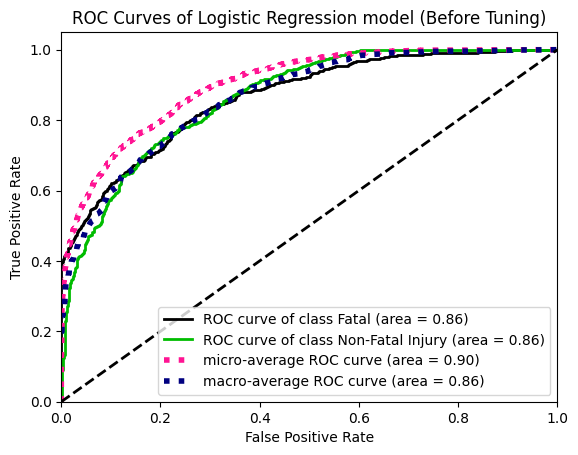

In [8]:
# Logistic Regression model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(x_train_prepared, y_train)

# Performance Evaluation - Before Tuning

# Cross-validation
crossvalscore = KFold(n_splits=10, random_state=42, shuffle=True)
scores = cross_val_score(log_reg, x_train_prepared,
                         y_train, cv=crossvalscore, scoring='accuracy')
print("\nCross Validation Scores (10 folds): ", scores)
print("Mean Cross Validation Score: ", scores.mean())

# Accuracy on training data
y_pred = log_reg.predict(x_train_prepared)
accuracy_train = accuracy_score(y_train, y_pred)
print("\nTraining Accuracy: ", accuracy_train)

# Accuracy on testing data
y_pred_test_before = log_reg.predict(x_test_transformed)
accuracy_test_before = accuracy_score(y_test, y_pred_test_before)
print("\nTesting Accuracy (Before Tuning): ", accuracy_test_before)

# Confusion Matrix (Before Tuning)
cfs_matrix_test_before = confusion_matrix(
    y_test, y_pred_test_before, labels=log_reg.classes_)
print("\nConfusion Matrix (Before Tuning):")
print(cfs_matrix_test_before)

# Classification Report (Before Tuning)
report = classification_report(y_train, y_pred)
print("\nClassification Report (Before Tuning):")
print(report)

# ROC Curve (Before Tuning)
y_probas = log_reg.predict_proba(x_test_transformed)
skplt.metrics.plot_roc_curve(y_test, y_probas)
plt.title('ROC Curves of Logistic Regression model (Before Tuning)')
plt.show()

In [9]:
# Define hyperparameter grid
param_grid = {
    'C': np.logspace(-4, 4, 50),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300, 400, 500]
}

# Randomized Search CV - Perform Grid Search for best parameters
grid = RandomizedSearchCV(log_reg, param_grid, cv=5, n_jobs=-1,
                          scoring='accuracy', n_iter=100, random_state=5)
grid.fit(x_train_prepared, y_train)

print("\nBest parameters: ", grid.best_params_)
print("\nBest estimator: ", grid.best_estimator_)
print("Best cross-validation score: ", grid.best_score_)

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter 


Best parameters:  {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 300, 'C': 4714.8663634573895}

Best estimator:  LogisticRegression(C=4714.8663634573895, max_iter=300, penalty='l1',
                   random_state=42, solver='liblinear')
Best cross-validation score:  0.788847104373877



Training Accuracy (After Tuning):  0.7916158107219979

Testing Accuracy (After Tuning):  0.799433962264151

Classification Report (After Tuning):
                  precision    recall  f1-score   support

           Fatal       0.38      0.70      0.49       735
Non-Fatal Injury       0.94      0.81      0.87      4565

        accuracy                           0.80      5300
       macro avg       0.66      0.76      0.68      5300
    weighted avg       0.87      0.80      0.82      5300



/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


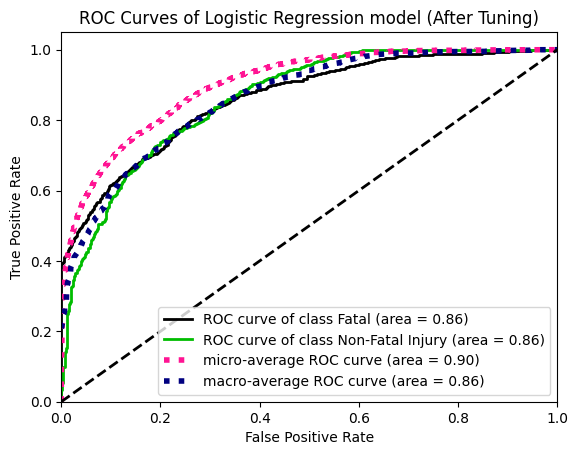

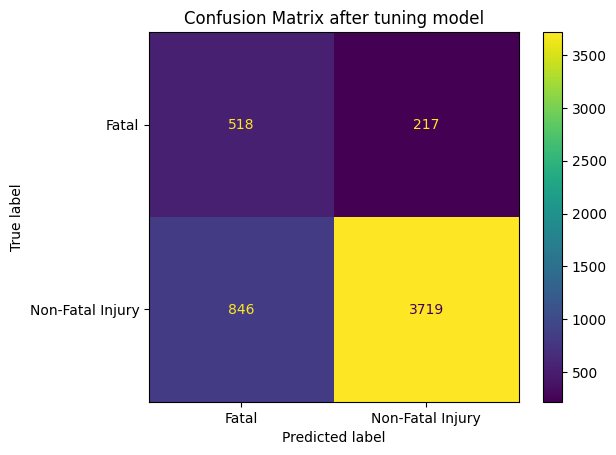

In [10]:
# Logistic Regression model with best parameters
log_reg_best = grid.best_estimator_

# Performance Evaluation - After Tuning

# Accuracy on training data
y_pred_train_after = log_reg_best.predict(x_train_prepared)
accuracy_train_after = accuracy_score(y_train, y_pred_train_after)
print("\nTraining Accuracy (After Tuning): ", accuracy_train_after)

# Accuracy on testing data
y_pred = log_reg_best.predict(x_test_transformed)
accuracy_test = accuracy_score(y_test, y_pred)
print("\nTesting Accuracy (After Tuning): ", accuracy_test)

# Classification Report (After Tuning)
report = classification_report(y_test, y_pred)
print("\nClassification Report (After Tuning):")
print(report)

# ROC Curve (After Tuning)
y_probas = log_reg_best.predict_proba(x_test_transformed)
skplt.metrics.plot_roc_curve(y_test, y_probas)
plt.title('ROC Curves of Logistic Regression model (After Tuning)')
plt.show()

# Confusion Matrix (After Tuning)
cfs_matrix = confusion_matrix(y_test, y_pred, labels=log_reg_best.classes_)
display = ConfusionMatrixDisplay(
    cfs_matrix, display_labels=log_reg_best.classes_)
display.plot()
plt.title("Confusion Matrix after tuning model")
plt.show()

In [11]:
# confusion matrix (after tuning)
print("Confusion Matrix:")
print(cfs_matrix)

Confusion Matrix:
[[ 518  217]
 [ 846 3719]]


In [12]:
# Save the tuned model for deployment
dump(log_reg_best, '../deployment/log_reg_model.pkl')

# Save the preprocessing pipeline for future data transformation
dump(log_reg_pipeline, '../deployment/log_reg_pipeline.pkl')

print("\nModel and Pipeline successfully dumped for deployment!")


Model and Pipeline successfully dumped for deployment!
